In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(font_scale=.75)

from sklearn.datasets import make_moons, make_classification, load_iris
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# Support Vector Machines

In [87]:
def create_meshgrid(X):
    return np.meshgrid(
            np.linspace(X[:, 0].min(), X[:, 0].max(), len(X)), 
            np.linspace(X[:, 1].min(), X[:, 1].max(), len(X))
        )

def predict_and_plot(clf, X, y, *, include_decision=True, ax=None):
    if ax is None:
        ax = plt.gca()

    cmap = plt.get_cmap("RdBu")
    mesh_x1, mesh_x2 = create_meshgrid(X)
    X_test = np.c_[mesh_x1.ravel(), mesh_x2.ravel()]

    y_pred = clf.predict(X_test).reshape(mesh_x1.shape)
    
    ax.contourf(mesh_x1, mesh_x2, y_pred, cmap=cmap, alpha=.5)

    if include_decision:
        y_desision = clf.decision_function(X_test).reshape(mesh_x1.shape)
        ax.contourf(mesh_x1, mesh_x2, y_desision, cmap=cmap, alpha=.25)

    sns.scatterplot(x=X[:, 0], y=X[:, 1], c=y, cmap=cmap, alpha=.8, ax=ax)
    score = cross_val_score(clf, X, y).mean()
    ax.text(1.5, .85, f"Score: {score:.2f}")
    ax.set(xlim=(mesh_x1.min()-.1, mesh_x1.max()+.1), ylim=(mesh_x2.min()-.1, mesh_x2.max()+.1))

In [53]:
X = np.array([[1, 5], [2, 6], [3, 6], [4, 8]])
meshgrid_x, meshgrid_y = create_meshgrid(X)

In [51]:
X

array([[1, 5],
       [2, 6],
       [3, 6],
       [4, 8]])

<Axes: >

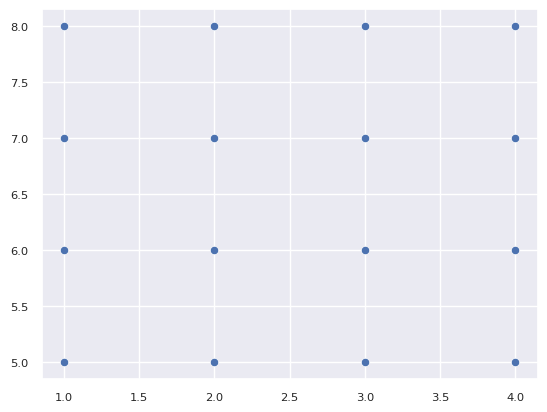

In [60]:
sns.scatterplot(x=meshgrid_x.ravel(), y=meshgrid_y.ravel())

In [97]:
X, y = make_moons(noise=.15, random_state=23)

In [63]:
np.c_[X[:5], y[:5]]

array([[ 0.07432171,  0.93074209,  0.        ],
       [ 1.18032261, -0.40873699,  1.        ],
       [ 1.46865226, -0.2693812 ,  1.        ],
       [ 0.60495729, -0.43706688,  1.        ],
       [ 1.15719742, -0.26109416,  1.        ]])

<Axes: >

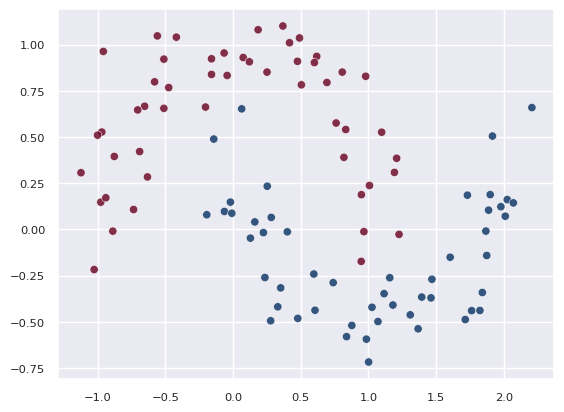

In [64]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.get_cmap("RdBu"), alpha=.8)

### LinearSVC

En linjär SVC får problem att hitta en passande linje eftersom klasserna inte är ickelinjärt uppdelade.

In [67]:
clf = make_pipeline(StandardScaler(), LinearSVC(C=10, max_iter=10000, dual=True, loss="hinge"))
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, dual=True, loss='hinge', max_iter=10000))])

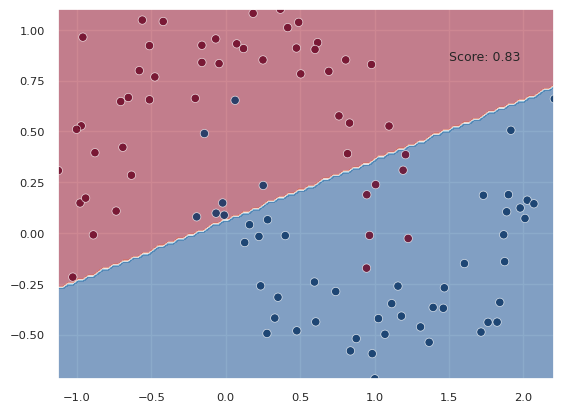

In [68]:
predict_and_plot(clf, X, y, include_decision=False)

Som vi såg förra veckan kan vi använda `PolynomialFeatures` för att skapa nya kolumner med ickelinjära *features*. Det hjälper vår `LinearSVC` ganska mycket.

In [69]:
poly_feat_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10000, dual=True, loss="hinge")
    )

poly_feat_clf.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, dual=True, loss='hinge', max_iter=10000))])

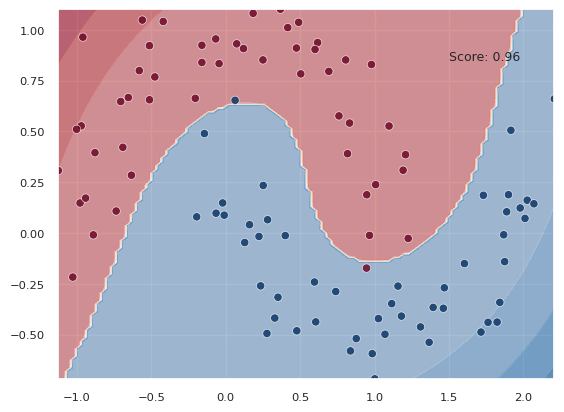

In [70]:
predict_and_plot(poly_feat_clf, X, y)

In [73]:
poly_feat_clf.named_steps["linearsvc"].coef_

array([[ 0.        , -1.09087618, -0.97204582, -4.61617409,  0.54234935,
         0.51495384,  6.97298781, -1.63481122,  1.09822082, -1.66131847]])

När vi använder *Support Vector Machines* finns det dock ett annat trick vi kan använda för att får fram ickelinjära relationer.

Istället för en `LinearSVC` kan vi använda en `SVC` och sätta `kernel`-parametern till `"poly"`.

Skillnaden är att en `SVC` med en *polynomial kernel* använder sig av ett matematiskt trick som ger samma resultat som om vi lade till *polynomial features*, utan att faktiskt behöva göra det, vilket sparar lagringsutrymme och beräkningskraft.

In [104]:
poly_kernel_clf = make_pipeline(
    StandardScaler(), 
    SVC(kernel="poly", degree=3, coef0=1, C=10))
poly_kernel_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, coef0=1, kernel='poly'))])

In [79]:
poly_kernel_clf_3 = make_pipeline(
    StandardScaler(), 
    SVC(kernel="poly", degree=3, coef0=1, C=10))

poly_kernel_clf_3.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, coef0=1, kernel='poly'))])

In [80]:
poly_kernel_clf_10 = make_pipeline(
    StandardScaler(), 
    SVC(kernel="poly", degree=10, coef0=1, C=10))
poly_kernel_clf_10.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, coef0=1, degree=10, kernel='poly'))])

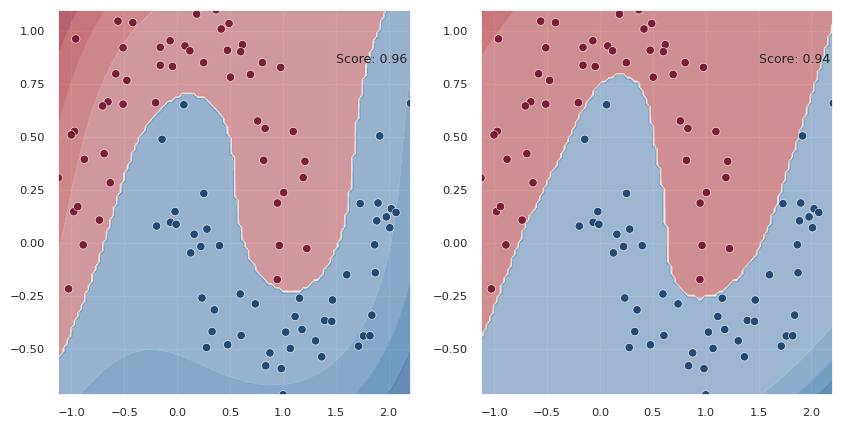

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

predict_and_plot(poly_kernel_clf_3, X, y, ax=axs[0])
predict_and_plot(poly_kernel_clf_10, X, y, ax=axs[1])

Vi kan använda `GridSearchCV` för att testa oss fram till de bästa värdena på hyperparametrarna. 

In [82]:
gsv_pipeline = make_pipeline(StandardScaler(), SVC(kernel="poly"))
param_grid = {
    "svc__degree": [2, 3, 5, 10],
    "svc__coef0": [0, 0.5, 1],
    "svc__C": [1, 10, 100]
}
gs_clf = GridSearchCV(gsv_pipeline, param_grid=param_grid)
gs_clf.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC(kernel='poly'))]),
             param_grid={'svc__C': [1, 10, 100], 'svc__coef0': [0, 0.5, 1],
                         'svc__degree': [2, 3, 5, 10]})

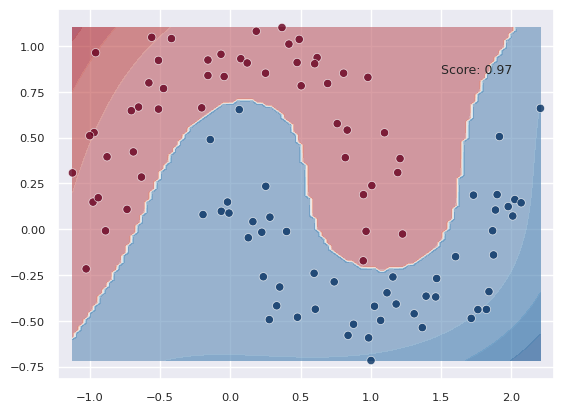

In [88]:
predict_and_plot(gs_clf, X, y)

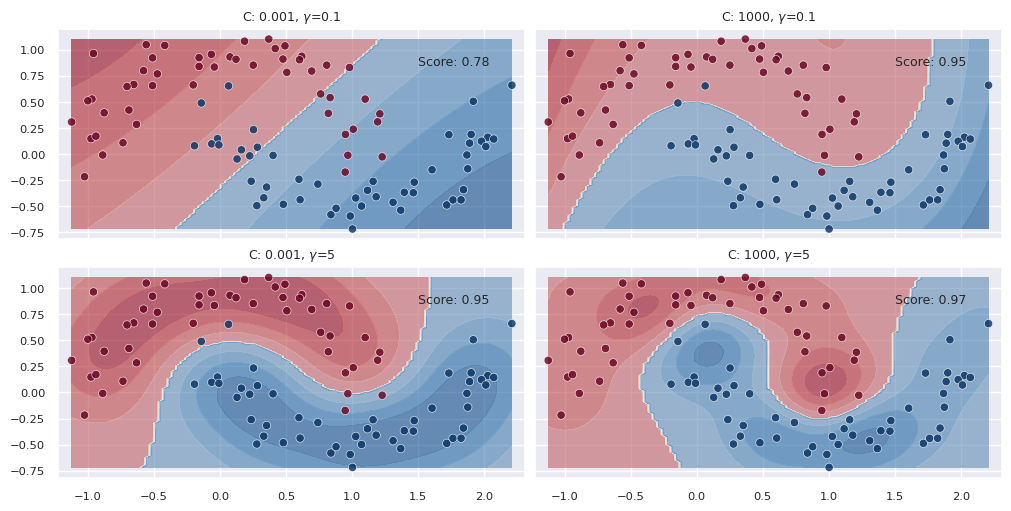

In [89]:
rbf1 = SVC(kernel="rbf", gamma=.1, C=.001)
rbf1.fit(X, y)

rbf2 = SVC(kernel="rbf", gamma=.1, C=1000)
rbf2.fit(X, y)

rbf3 = SVC(kernel="rbf", gamma=5, C=.001)
rbf3.fit(X, y)

rbf4 = SVC(kernel="rbf", gamma=5, C=1000)
rbf4.fit(X, y)

fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True, layout="constrained")

for ax, model in zip(axs.flatten(), [rbf1, rbf2, rbf3, rbf4]):
    predict_and_plot(model, X, y, ax=ax)
    ax.set(title=f"C: {model.get_params()["C"]}, $\\gamma$={model.get_params()["gamma"]}")
    # print(ax)


In [91]:
gsv_pipeline = make_pipeline(StandardScaler(), SVC(kernel="rbf"))
param_grid = {
    "svc__gamma": [.1, 1, 5, 50, 100]
    "svc__C": [1, 10, 100]
}
gs_clf = GridSearchCV(gsv_pipeline, param_grid=param_grid)
gs_clf.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [1, 10, 100],
                         'svc__gamma': [0.1, 1, 5, 50, 100]})

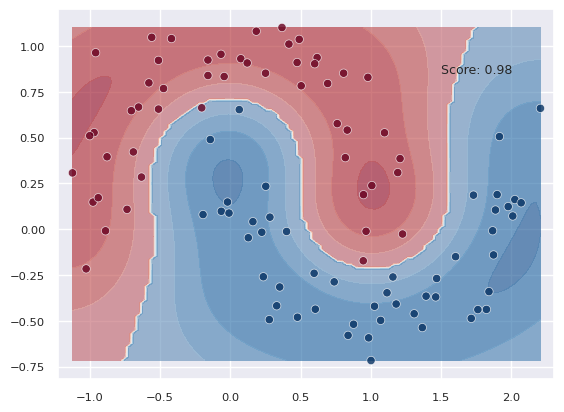

In [98]:
predict_and_plot(gs_clf, X, y)

In [99]:
X, y = make_moons(n_samples=200, noise=.15, random_state=16)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [100]:
gs_clf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [1, 10, 100],
                         'svc__gamma': [0.1, 1, 5, 50, 100]})

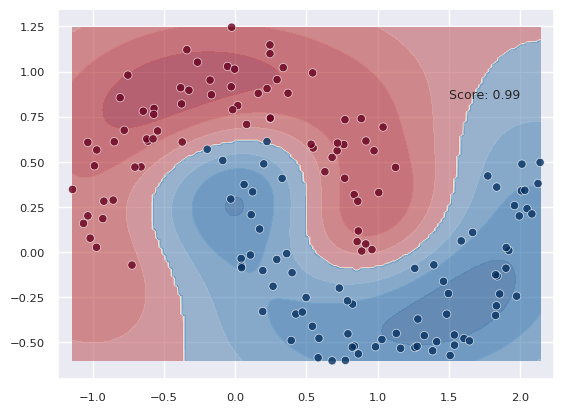

In [101]:
predict_and_plot(gs_clf, X_train, y_train)

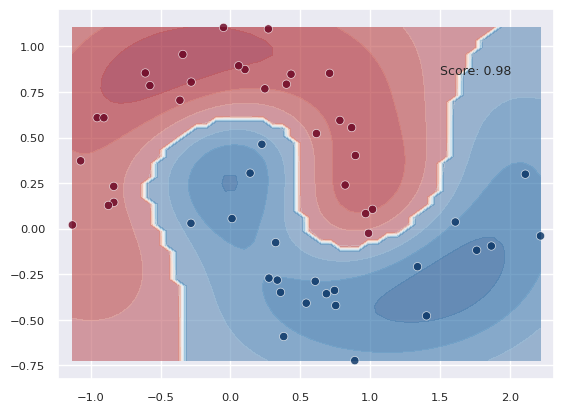

In [102]:
predict_and_plot(gs_clf, X_test, y_test)

In [103]:
X_iris, y_iris = load_iris(return_X_y=True)

# Create new features and only keep them
X_areas = np.zeros((X_iris.shape[0], 2))
X_areas[:, 0] = X_iris[:, 0] * X_iris[:, 1]
X_areas[:, 1] = X_iris[:, 2] * X_iris[:, 3]

X_train, X_test, y_train, y_test = train_test_split(X_areas, y_iris, random_state=23)

In [105]:
poly_kernel_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, coef0=1, kernel='poly'))])

In [106]:
xx, yy = create_meshgrid(X_train)
xxyy = np.c_[xx.ravel(), yy.ravel()]
y_pred = poly_kernel_clf.predict(xxyy).reshape(xx.shape)

<Axes: >

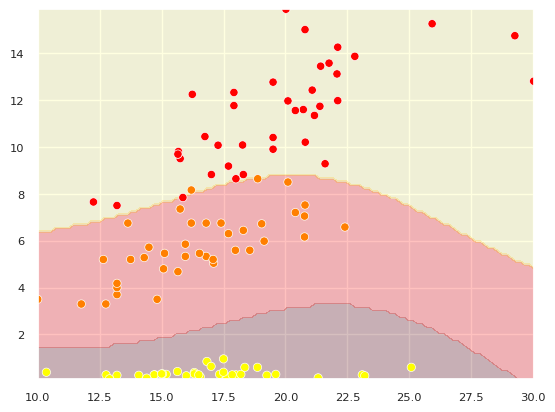

In [107]:
cmap = "hot"
plt.contourf(xx, yy, y_pred, levels=3, cmap=cmap, alpha=.25)
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], c=y_train, cmap="autumn_r")

In [108]:
X_iris, y_iris = load_iris(return_X_y=True)
X_iris = X_iris[y_iris != 0]
y_iris = y_iris[y_iris != 0]

# Create new features and only keep them
X_areas = np.zeros((X_iris.shape[0], 2))
X_areas[:, 0] = X_iris[:, 0] * X_iris[:, 1]
X_areas[:, 1] = X_iris[:, 2] * X_iris[:, 3]

X_train, X_test, y_train, y_test = train_test_split(X_areas, y_iris, random_state=23)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train, y_train)
# X_test = scaler.transform(X_test, y_test)

<Axes: >

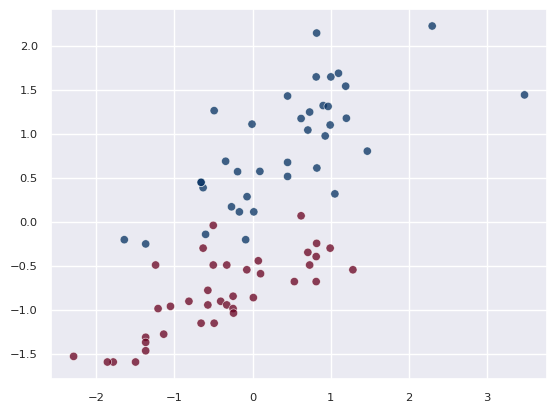

In [109]:
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], c=y_train, cmap=plt.get_cmap("RdBu"), alpha=.75)

In [110]:
poly_kernel_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, coef0=1, kernel='poly'))])

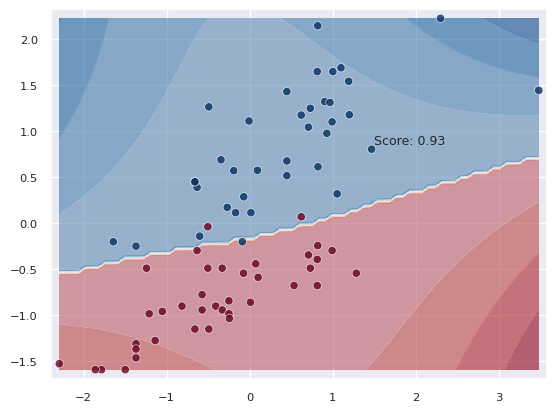

In [111]:
predict_and_plot(poly_kernel_clf, X_train, y_train)

In [28]:
y_pred = cross_val_predict(poly_kernel_clf, X_train, y_train)
cm = confusion_matrix(y_train, y_pred)

In [ ]:
ConfusionMatrixDisplay(cm).plot(cmap=plt.get_cmap("RdBu"), text_kw={"c": "white"})
plt.grid(False)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [ ]:
predict_and_plot(logreg, X_train, y_train)